# Notebook BEP

Table of contents:  
 
1. Holography
2. Optical coherence tomography
3. Compressed sensing
4. Compressed sensing\optical coherence tomography example


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
import itertools as itr
import math
from scipy import signal
from scipy import fft as spfft
import cvxpy as cvx

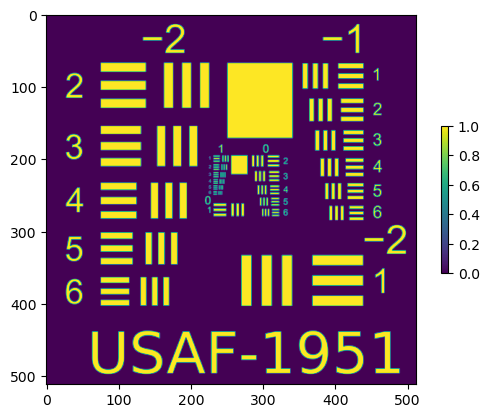

In [2]:
N=512 #desired resolution

# load images
image_1=io.imread('usaf.png')[:,:,3]/255

# making image square
A,B=image_1.shape
NN=1*np.max([A,B])
data_1_complete=np.pad(image_1,((int((NN-A)/2),int((NN-A)/2)),(int((NN-B)/2),int((NN-B)/2))))
data_1 = resize(data_1_complete, (N,N)) #resize data to wanted resolution
plt.imshow(data_1)
plt.colorbar(shrink=0.4)
plt.show()

# setting parameters for the camera
L=20e-3         # (m)
deltax0=L/N

# defining extent for producing images
extentx=1e3*np.array([-L/2, L/2, -L/2, L/2])

# setting up coordinate systems
x=np.linspace(-L/2, L/2-deltax0,N) # x and y coordinate of the object
xx,yy=np.meshgrid(x,np.flip(x))
fx=np.linspace(-1/2/deltax0, 1/2/deltax0-1/L, N)
fxx,fyy=np.meshgrid(fx,np.flip(fx))

# create distance profile
dist = 2e-6*(2/L)*xx

## Holography

**prop_TF** (*prop_len*: propagation distance ; *wavlen*: wavelength; *u0*: wavefield): <br> function for propagating a wavefield between 2 planes unsing the angular spectrum method

**obj_gen**(*data*: amplitude of an object ; *dist*: distance profile of an object ; *wav*: wavelength): <br> generates a phase profile/wavefield for an object based on a heigth profile and the amplitude of an object 

**comp**(*w*: array of wavelenghts): <br> calculates the synthetic wavelenght according to the following formula  
$$\frac{1}{\lambda_{synt}} = \frac{1}{\lambda_{1}} - \frac{1}{\lambda_{2}} + \frac{1}{\lambda_{3}} - \frac{1}{\lambda_{4}} + \frac{1}{\lambda_{5}} - \frac{1}{\lambda_{6}} + \frac{1}{\lambda_{7}} - ...$$

**recon_dist**(*wav*: wavelength ; *u*: wavefield): <br> reverse of obj_gen, generates a height profile based on a phase profile and a (synthetic) wavelenght

**order**(*w*: array of wavelengths): <br> function to find the best ordering of wavelenghts to achieve the maximum synthetic wavelength (note: this is not optimised, so don't throw in too many wavelenghts)

**interfere_filter**(*theta*: angle of reference field ; *wavelen*: wavelength ; *u1*: wavefield ; *intens*: intensity of reference field): <br>Interferes a wavefield with a reference field (plane wave under an angle), transforms it into the fourier space and filters out the cross-terms here before transforming it back and shifting it to the center.

**wavefront**(*wavelen*: wavelength ; *theta*: angle of reference field ; *prop*: propagation distance ; *data*: amplitude of an object ; *dist*: distance profile of an object ; *intens*: intensity of reference field): <br> Generates a wavefield based on countour and distance data, propagates it to the camere, interferes it with the reference field under an andgle and propagates it back to the object location.

**multiple**(*wavelen*: array of wavelengths ; *theta*: angle of reference field ; *prop*: propagation distance ; *data*: amplitude of an object ; *dist*: distance profile of an object ; *intens*: intensity of reference field): <br> Generates multiple wavefield reconstructions for a set of wavelengths

**full_recon**(*wavelen*: array of wavelengths ; *theta*: angle of reference field ; *prop*: propagation distance ; *data*: amplitude of an object ; *dist*: distance profile of an object ; *intens*: intensity of reference field): <br>
***note*** *: only takes even lengths of arrays* <br> Fully reconstructs an object when given the proper data and an array of wavelenghts. It orders the wavelenghts for an optimal synthetic wavelenght, reconstructs the wavefield for each of them, combines them into a wavefield with the synthestic wavelenght, and reconstructs the object using this wavelenght.  

In [3]:
def prop_TF(prop_len, wavlen, u0):
    #Transfer function
    H = np.exp(1j*2*np.pi*prop_len*np.sqrt((wavlen**(-2)-fxx**2-fyy**2)))

    # propagation
    U0=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(u0)))
    U1=U0*H
    u1=np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(U1)))

    return u1

def obj_gen(data, dist, wav):
    k=2*np.pi/wav 
    shift = k*dist 
    u0 = 1*np.exp(1j*shift)*data
    return u0

def comp(wav):
    inv = 1/wav
    inv[1::2] = -inv[1::2]
    comp = 1/np.sum(inv)
    return comp

def recon_dist(w, u):
    wav = comp(w)
    k = 2*np.pi/wav
    ang = np.angle(u)
    dist = ang/k
    return dist

def order(w): #please do note that this function is poorly optimised
        # getting nececssary parameters, setting up arrays
    n = len(w)
    a = np.linspace(0,n-1,n)
    f = math.factorial(n)
    arr = np.zeros((f,n))
    i = 0
    # these 2 for-loops generate all possible permutations
    for x in itr.permutations(a, n):
        arr[i] = x
        i += 1
    for j in range(n):
        np.place(arr, arr==j, w[j])
    # calculating eventual synthetic wavelenght and finding maximum 
    swav_arr = np.apply_along_axis(comp, 1, arr)
    max = np.max(swav_arr)
    imax = np.where(swav_arr == max)[0]
    wavmax = arr[imax,:]
    # only need the permuation with the maximum wavelenght 
    return wavmax[0]

def interfere_filter(theta, wavelen, u1, intens):
    # Calculate reference field
    k=2*np.pi/wavelen
    ur=intens*1.0*np.exp(-1j*k*np.sin(theta)*(xx+yy))
    # calculate interference
    u_tot =ur+u1
    holo = np.abs(u_tot)**2 - np.real(np.conj(ur)*ur)# - np.real(np.conj(u1)*u1)

    # constructing mask and filtering
    f_shift = np.sin(theta)/wavelen
    holo_fft = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(holo)))
    filter=(1*np.sqrt((fxx-f_shift)**2 + (fyy-f_shift)**2)) > f_shift 
    holo_fft[filter] = 0
    holo_filt=np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(holo_fft)))
    holo_filt = holo_filt*ur # shifting back to center

    return holo_filt

def wavefront(wavelen,theta, prop, dist,data,intens):
    u0 = obj_gen(data,dist,wavelen)
    u1 = prop_TF(prop,wavelen,u0)
    u_filt = interfere_filter(theta, wavelen, u1,intens)
    u_back = prop_TF(-prop,wavelen,u_filt)
    return u_back

def multiple(wavelength,theta,prop,dist,data,intens):
    u_back = np.zeros((len(wavelength),N,N), dtype=complex)

    for i in range(len(wavelength)):
        a = wavefront(wavelength[i],theta,prop,dist,data,intens)
        u_back[i] = a

    return u_back

def full_recon(wavelength,theta,prop,dist,data,intens):
    n = len(wavelength) 
    # check that length of array is even
    if n % 2 != 0:
        print("please use even lenght of array")
        return
    
    # finding maximum synthetic wavelength
    wavelength = order(wavelength)
    print(wavelength)
    print(comp(wavelength))

    # calculating and combining holograms 
    u_back =multiple(wavelength,theta,prop,dist,data,intens)
    u_comp = 1
    
    a = np.linspace(0, n-1, n)[1::2]
    
    for i in a:
        u_comp = u_comp*u_back[int(i-1)]*np.conj(u_back[int(i)])

    # reconstructing distance profile
    r_d = recon_dist(wavelength, u_comp)
    return r_d*np.abs(u_back[0])

## Optical Coherence Tomography
**image_peaks**(*izs*: OCT image ; *z*: z-axis for displaying image ; *cutx*: x-coordinate for imaging ; *cuty*: x-coordinate for imaging ; *prom*: prominence of peaks): <br> finds the peaks of a signal and displays a crossection for each peak, along with a depth profile (cuty) and an a-scan (cutx,cuty), selects all peaks above a certain prominence. The returned value is the index on axis 2 of the peaks in the OCT image.

**inline_OCT_prop**(*z0*: propagation distance ; *distr*: depth of reflectors ; *k*: array of wavenumbers ; *intens*:array of the intensity as function of  wavenumber ; *fields*: Object fields of reflectors ): <br> generates an inline OCT signal in k-domain based on array of wavenumbers, depth of the reflectors and their shape. <br>
***note*** *: This function only takes amplitude fields, to use a height profile obj_gen should be included in the function*

**OA_OCT_prop**(*z0*: propagation distance ; *distr*: depth of reflectors ; *k*: array of wavenumbers ; *intens*:array of the intensity as function of  wavenumber ; *fields*: <br> Object fields of reflectors ; *theta*: angle of reference field): <br> generates an off-axis OCT signal in k-domain based on array of wavenumbers, depth of the reflectors and their shape. <br>
***note*** *: This function only takes amplitude fields, to use a height profile obj_gen should be included in the function*

**extract**(*sig*: signal): <br> extracts the unwrapped instantaneous phase using Hilbert transform

**phase_extract**(*sig*: signal ; *prom*: prominence of peaks ; *z* z-axis ; *deltaz* z-axis interval): <br> extracts the unwrapped instantaneous phase for all peaks in a signal, selects all peaks above a certain prominence.

**phase_distance**(*sig*: signal ; *prom*: prominence of peaks ; *deltak*: wavenumber interval *z* z-axis ; *deltaz* z-axis interval): <br>
Determines location of peaks using the Hilbert transform.

***mod***: These two functions are the same as the previous ones, only using the highest peaks in the signal instead of selecting peaks based on prominence, the number of peaks can be set using *peak_n*


In [16]:
def image_peaks(izs, z, cutx, cuty, prom):
    # finding peaks
    peaks = signal.find_peaks(np.abs(izs[cutx,cuty,:]), prominence=prom)[0]

    # plotting a-scan and depth profile
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    plt.plot(1e6*z, np.abs(izs[cutx,cuty,:]))
    plt.plot(1e6*z[peaks],np.abs(izs[cutx,cuty,:][peaks]),'xr')
    plt.subplot(1,2,2)
    plt.imshow(np.abs(izs[:,cuty,:]), aspect = 'auto')
    plt.show()

    # plotting the different peaks
    tot = len(peaks)
    lines = np.ceil(tot/4)
    lines = lines.astype(int)
    plt.figure(figsize=(20,4*lines))
    for j in range(lines):
        if tot > 4: 
            i = 4*j
            tot = tot-4
            plt.subplot(lines, 4, i+1)
            plt.imshow(np.abs(izs[:,:,peaks[i]]))
            plt.subplot(lines, 4, i+2)
            plt.imshow(np.abs(izs[:,:,peaks[i+1]]))
            plt.subplot(lines, 4, i+3)
            plt.imshow(np.abs(izs[:,:,peaks[i+2]]))
            plt.subplot(lines, 4, i+4)
            plt.imshow(np.abs(izs[:,:,peaks[i+3]]))
        else:
            plt.show()
            plt.figure(figsize=(20,4))
            print(tot)
            for i in range(tot):
                plt.subplot(1,tot,i+1)
                plt.imshow(np.abs(izs[:,:,peaks[(j*4)+i]]))
            plt.show()     
    return peaks

def inline_OCT_prop(z0, distr, k, intens, fields):
    # setting up propagation distance and arrays
    dist_obj = distr + z0
    I = np.zeros((N,N ,len(k)), dtype=complex)
    holo = np.zeros((N,N ,len(k)), dtype=float)

    for i in range(len(k)): # iterating trough different wavenumbers 
        print(i+1,'/',int(len(k)))
        wav = 2*np.pi/k[i]
        u_ref = intens[i]*10*np.exp(1j*k[i]*z0)
        u_tot = u_ref
        for j in range(fields.shape[2]): #propagating and adding different reflectors
            u = intens[i]*prop_TF(dist_obj[j], wav, fields[:,:,j])
            u_tot = u_tot + u
        # Interfering and filtering autocorrelation for reference term
        holo = np.abs(u_tot)**2 
        I_filt = holo - np.abs(u_ref**2)
        I[:,:,i] = prop_TF(-z0, wav,I_filt)/np.conj(u_ref)
    return I

def OA_OCT_prop(z0, distr, k, intens, fields, theta):
    # setting up propagation distance and arrays
    dist_obj = distr + z0
    I = np.zeros((N,N ,len(k)), dtype=complex)
    for i in range(len(k)): # iterating trough different wavenumbers 
        print(i+1,'/',int(len(k)))
        wav = 2*np.pi/k[i]
        u_tot = 0
        for j in range(fields.shape[2]): #propagating and adding different reflectors
            u = intens[i]*prop_TF(dist_obj[j], wav, fields[:,:,j])
            u_tot = u_tot + u
        I_filt = interfere_filter(theta,wav,u_tot,intens[i]) #interfering and off-axis filtering 
        I[:,:,i] = prop_TF(-z0, wav, I_filt)
    return I

def extract(sig):
    analytic_sig = signal.hilbert(np.real(sig))
    phase = np.unwrap(np.angle(analytic_sig))
    return phase

def phase_extract(sig, prom, z, deltaz):
    peaks = signal.find_peaks(np.abs(sig), prominence=prom)[0]  #finding peaks
    phase = np.zeros((len(peaks),len(sig)))
    for i in range(len(peaks)):
        sigf = np.zeros((N,N ,len(sig)), dtype=float)
        ubackf = np.zeros((N,N ,len(sig)), dtype=float)
        sigf = np.copy(sig)
        window = np.abs(z - z[peaks[i]]) > 1*deltaz # isolating peak
        sigf[window] = 0
        ubackf = np.fft.fft(np.fft.fftshift(sigf)) # transforming back to k-domain
        phase[i,:] = extract(ubackf) # extracting phase
    return phase

def phase_distance(sig, prom, deltak, z, deltaz):
    l = len(sig)
    start = int(l/4)
    a = phase_extract(sig, prom, z, deltaz)[:,start:-start+1]
    b = np.diff(a) / (2*deltak) 
    
    #for i in range(len(a)):
    #    plt.plot(a[i])
    #plt.show()

    #for i in range(len(a)):
    #    plt.plot(b[i])
    #plt.show()

    return np.mean(b,axis=1)

def phase_extract_mod(sig, z, deltaz, peak_n):
    peaks = signal.find_peaks(np.abs(sig))[0]
    peaks = peaks[np.argpartition(np.abs(sig[peaks]), -peak_n)[-peak_n:]]
    phase = np.zeros((len(peaks),len(sig)))
    for i in range(len(peaks)):
        sigf = np.zeros((N,N ,len(sig)), dtype=float)
        ubackf = np.zeros((N,N ,len(sig)), dtype=float)
        sigf = np.copy(sig)
        window = np.abs(z - z[peaks[i]]) > 1*deltaz
        sigf[window] = 0
        ubackf = np.fft.fft(np.fft.fftshift(sigf))
        phase[i,:] = extract(ubackf)
    return phase

def phase_distance_mod(sig, peak_n, deltak, z, deltaz):
    l = len(sig)
    start = int(l/4)
    a = phase_extract_mod(sig, z, deltaz, peak_n)[:,start:-start+1]
    b = np.diff(a) / (2*deltak)
    
    #for i in range(len(a)):
    #    plt.plot(a[i])
    #plt.show()

    #for i in range(len(a)):
    #    plt.plot(b[i])
    #plt.show()
    
    return np.mean(b, axis=1)

## Compressed sensing

**recon**(*I_comp*: undersampled signal ; *N*: number of samples in original signal): <br> Reconstruction of a signal using compressed sensing for real signals.

**recon_cp**(*I_comp*: undersampled signal ; *N*: number of samples in original signal): <br> Reconstruction of a signal using compressed sensing for complex signals.

***note*** : The matrix A still needs to be set up outside of this figure, as seen in the examples

In [17]:
def recon(I_comp,N):
    # setting up problem and minimising l1 norm
    vx = cvx.Variable(N)
    objective = cvx.Minimize(cvx.norm(vx, 1))
    constraints = [A@vx == I_comp]
    prob = cvx.Problem(objective, constraints)
    result = prob.solve(verbose=False)
    # transforming signal so that fft is used instead of dct, dct is used in reconstruction due to limitations of package
    x = np.array(vx.value)
    sig = spfft.dct(x)
    recon = np.fft.fftshift(np.fft.ifft(sig))
    return np.abs(recon)

def recon_cp(sub, N):
    # splitting imaginary and real part
    subr = np.real(sub)
    subi = np.imag(sub)

    # setting up problems and minimising l1 norm
    vxr = cvx.Variable(N)
    objective = cvx.Minimize(cvx.norm(vxr, 1))
    constraints = [A@vxr == subr]
    probr = cvx.Problem(objective, constraints)
    resultr = probr.solve()

    vxi = cvx.Variable(N)
    objective = cvx.Minimize(cvx.norm(vxi, 1))
    constraints = [A@vxi == subi]
    probi = cvx.Problem(objective, constraints)
    resultr = probi.solve()

    # transforming signal so that fft is used instead of dct, dct is used in reconstruction due to limitations of package
    xr = np.array(vxr.value)
    yr = spfft.dct(xr)

    xi = np.array(vxi.value)
    yi = spfft.dct(xi)

    # combining imaginary and real part
    y = yr + 1j*yi

    return np.fft.fftshift(np.fft.ifft(y))

## Examples

In [18]:
# setting up spectral intensity for OCT
lambdac=950e-9
dlambda=150e-9
P0=1e-3
tau=1e-6
N_l=128
mult = 4
N_lsub = N_l*mult

kc=2*np.pi/lambdac
dk=dlambda*2*np.pi/lambdac**2             # FWHM_k
sigmak = dk/(2*np.sqrt(2*np.log(2)))        # std
kmin=kc-dk                        # 2*dk is necessary to avoid problems in the z-domain
kmax=kc+dk

# setting up intervals
k=np.linspace(kmin,kmax,N_l) 
ksub = np.linspace(kmin,kmax,N_lsub)
deltak=k[2]-k[1]
deltaksub = ksub[2]-ksub[1]
z=np.linspace(-0.5*np.pi/deltak, 0.5*np.pi/deltak, N_l)
zsub=np.linspace(-0.5*np.pi/deltaksub, 0.5*np.pi/deltaksub, N_lsub)
deltaz=z[2]-z[1]
deltazsub = zsub[2]-zsub[1]

# intensity
intens=P0/(np.sqrt(2*np.pi*sigmak**2))*np.exp(-(k-kc)**2/(2*sigmak**2))

intensub=P0/(np.sqrt(2*np.pi*sigmak**2))*np.exp(-(ksub-kc)**2/(2*sigmak**2))

1 / 128
2 / 128
3 / 128
4 / 128
5 / 128
6 / 128
7 / 128
8 / 128
9 / 128
10 / 128
11 / 128
12 / 128
13 / 128
14 / 128
15 / 128
16 / 128
17 / 128
18 / 128
19 / 128
20 / 128
21 / 128
22 / 128
23 / 128
24 / 128
25 / 128
26 / 128
27 / 128
28 / 128
29 / 128
30 / 128
31 / 128
32 / 128
33 / 128
34 / 128
35 / 128
36 / 128
37 / 128
38 / 128
39 / 128
40 / 128
41 / 128
42 / 128
43 / 128
44 / 128
45 / 128
46 / 128
47 / 128
48 / 128
49 / 128
50 / 128
51 / 128
52 / 128
53 / 128
54 / 128
55 / 128
56 / 128
57 / 128
58 / 128
59 / 128
60 / 128
61 / 128
62 / 128
63 / 128
64 / 128
65 / 128
66 / 128
67 / 128
68 / 128
69 / 128
70 / 128
71 / 128
72 / 128
73 / 128
74 / 128
75 / 128
76 / 128
77 / 128
78 / 128
79 / 128
80 / 128
81 / 128
82 / 128
83 / 128
84 / 128
85 / 128
86 / 128
87 / 128
88 / 128
89 / 128
90 / 128
91 / 128
92 / 128
93 / 128
94 / 128
95 / 128
96 / 128
97 / 128
98 / 128
99 / 128
100 / 128
101 / 128
102 / 128
103 / 128
104 / 128
105 / 128
106 / 128
107 / 128
108 / 128
109 / 128
110 / 128
111 / 12

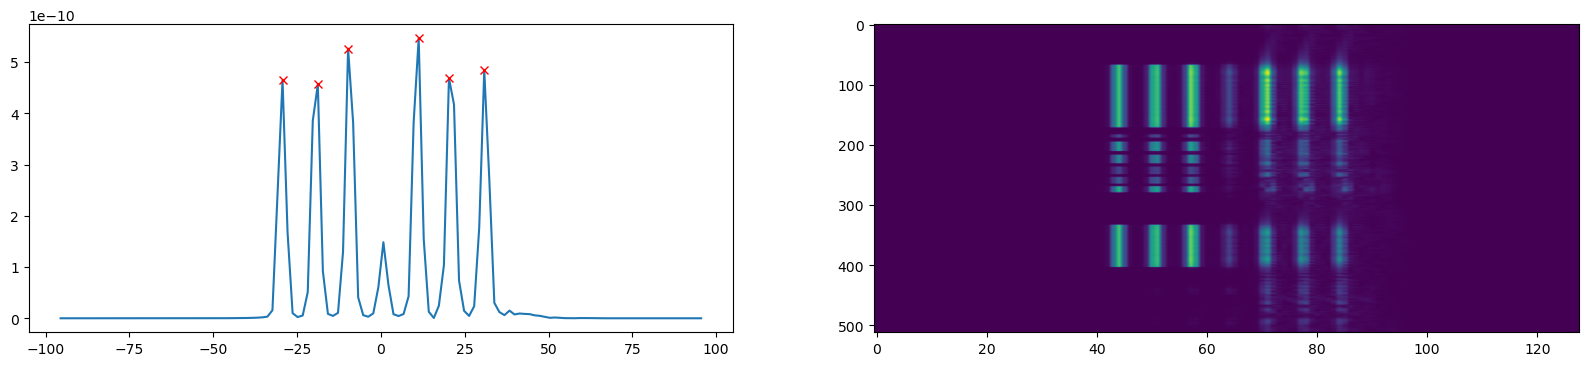

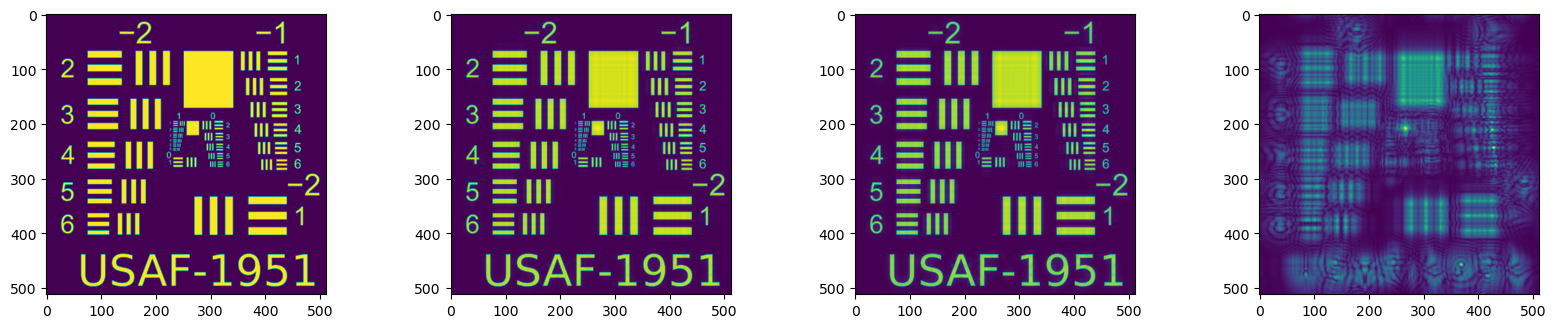

2


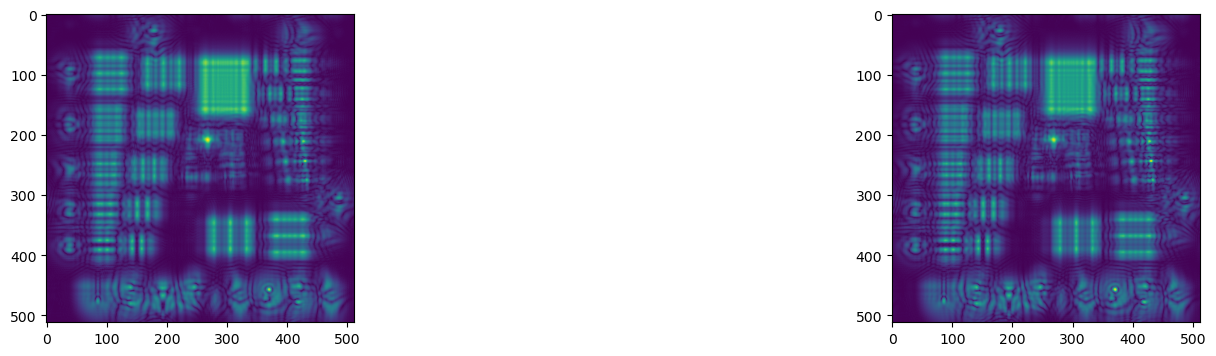

[-2.93312500e-05 -1.88020833e-05 -9.77708333e-06  1.12812500e-05
  2.03062500e-05  3.08354167e-05]
[2.99968842e-05 1.99451479e-05 1.00230604e-05 1.00684526e-05
 1.99621218e-05 3.00314339e-05]


In [23]:
z0 = 0.2 
zmir = 10e-6
distr = zmir*np.array((1,2,3))*2 # location of the reflectors
theta=0.3*np.pi/180

cutx = 100
cuty = 300

field = np.stack((data_1,data_1,data_1),axis=2)

# inline OCT
I = inline_OCT_prop(z0, distr, k, intens, field)
iz = np.fft.fftshift(np.fft.ifft(I, axis=2),axes=2)
print('location determined using the maximum of the psf and the Hilbert transform')
peaks = image_peaks(iz, z, cutx, cuty, 2e-10)
print(z[peaks])
print(phase_distance(iz[cutx,cuty,:], 2e-10, deltak, z, deltaz))

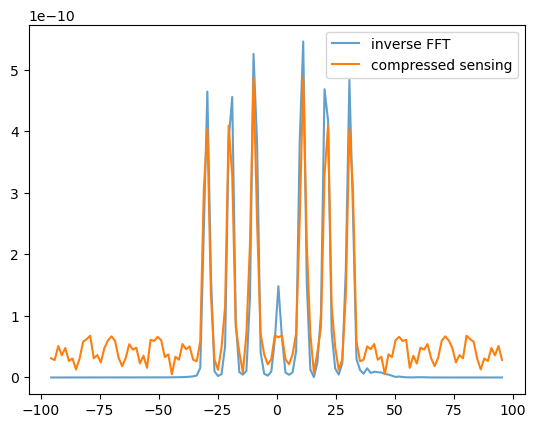

In [29]:
# reconstruction for an a-scan
i_comp = np.sort(np.random.choice(N_l, 100 , replace=False))
I_comp = I[:,:,i_comp]
A_full = spfft.dct(np.identity(N_l))
A = A_full[i_comp]
reco = recon(I_comp[cutx,cuty,:], N_l)

plt.plot(1e6*z,np.abs(iz[cutx,cuty,:]), alpha=0.7, label='inverse FFT')
plt.plot(1e6*z,np.abs(reco), label='compressed sensing')
plt.legend()
plt.show()

In [24]:
# reconstruction of complete OCT image
i_comp = np.sort(np.random.choice(N_l, 60, replace=False))
I_comp = I[:,:,i_comp]
A_full = spfft.dct(np.identity(N_l))
A = A_full[i_comp]

ir = np.zeros((N,N,N_l), dtype= complex)
i = 0
j = 0
for j in range(N):
    for i in range(N):
        print(j*N + i + 1, '/', N**2)
        ir[i,j,:] = recon_cp(I_comp[i,j,:],N_l)

1 / 262144
2 / 262144
3 / 262144
4 / 262144
5 / 262144
6 / 262144
7 / 262144
8 / 262144
9 / 262144
10 / 262144
11 / 262144
12 / 262144
13 / 262144
14 / 262144
15 / 262144
16 / 262144
17 / 262144
18 / 262144
19 / 262144
20 / 262144
21 / 262144
22 / 262144
23 / 262144
24 / 262144
25 / 262144
26 / 262144
27 / 262144
28 / 262144
29 / 262144
30 / 262144
31 / 262144
32 / 262144
33 / 262144
34 / 262144
35 / 262144
36 / 262144
37 / 262144
38 / 262144
39 / 262144
40 / 262144
41 / 262144
42 / 262144
43 / 262144
44 / 262144
45 / 262144
46 / 262144
47 / 262144
48 / 262144
49 / 262144
50 / 262144
51 / 262144
52 / 262144
53 / 262144
54 / 262144
55 / 262144
56 / 262144
57 / 262144
58 / 262144
59 / 262144
60 / 262144
61 / 262144
62 / 262144
63 / 262144
64 / 262144
65 / 262144
66 / 262144
67 / 262144
68 / 262144
69 / 262144
70 / 262144
71 / 262144
72 / 262144
73 / 262144
74 / 262144
75 / 262144
76 / 262144
77 / 262144
78 / 262144
79 / 262144
80 / 262144
81 / 262144
82 / 262144
83 / 262144
84 / 262144
8